# Tarea 3: Diseño Avanzado de Algoritmos

## k-means

### Daniel San Martín

In [32]:
# Python version 3.7.3
import os 
import numpy as np # Version 1.16.4
import pandas as pd # Version 0.24.2
import matplotlib.pyplot as plt # Version 3.1.0
from mpl_toolkits.mplot3d import Axes3D 
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances # Version 0.21.2
import warnings
warnings.filterwarnings("ignore")

In [33]:
DATA_DIR = 'data/dataset.csv'

### Funciones auxiliares

Implementación de funciones para la representacion de datos, graficar y obtener resultados.

In [34]:
def dataRepresentation(data, matrix=True): 
    M, N = np.max(data['source']), np.max(data['target'])  
    m = np.zeros((M, N))
    d = dict()
    
    for index, row in data.iterrows():
        s, t, r = row['source'], row['target'], row['rating']
        m[s-1, t-1] = r
        if s not in d:
            d[s] = np.zeros(N)
        d[s][t-1] = r
    
    if matrix:
        # Remove rows with only zero
        m_f = m[~np.all(m == 0, axis=1)]
        return m_f
    else:
        return d

In [35]:
def boxplot(data, times=True):
    N = len(data)
    fig, axes = plt.subplots(1, N, figsize=(15, 5), sharey=True)
    for k in range(N):
        if times: axes[k].boxplot(data[k].all_runs)
        else: axes[k].boxplot(data[k])
        axes[k].set_title("K = " + str((k+1)*10))
        axes[k].grid(True)
    plt.tight_layout()
    plt.show()        

In [36]:
def scatter(data, means=None):
    fig = plt.figure(figsize=(14, 4))

    # First subplot
    ax = fig.add_subplot(1, 2, 1)
    if means is not None:
        scatter_2D = ax.scatter(data.source, data.target, s=data.rating*10, c=data.rating, alpha=.5)
        ax.scatter(means[:,0], means[:,1], c=means[:,2], s=300, marker="*", edgecolor='k', alpha=1)
    else:
        scatter_2D = ax.scatter(data.source, data.target, s=data.rating*100, c=data.rating, alpha=.5)
    cb = plt.colorbar(scatter_2D, ax=ax, ticks=[-10, 0, 10])
    cb.set_label('RATING')
    ax.grid(True)
    ax.set_xlabel("ID_SOURCE")
    ax.set_ylabel("ID_TARGET")

    # Second subplot
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    
    if means is not None:
        ax.scatter(means[:,0], means[:,1], means[:,2], s=500, marker='*', 
                   c=means[:,2], edgecolor='k', alpha=1)
        ax.scatter(data.source, data.target, data.rating, c=data.rating, alpha=.1, s=1)
    else:
        ax.scatter(data.source, data.target, data.rating, c=data.rating, alpha=.5, s=10)
        
    ax.set_xlabel("ID_SOURCE")
    ax.set_ylabel("ID_TARGET")
    ax.set_zlabel("RATING")

    plt.show()

In [37]:
def histogram(data):
    # Remove duplicated data for symmetry
    data_u = np.triu(data, k=1) # Get upper triadiagonal without diagonal
    data_u = data_u.flatten() # Vectorize matrix
    data_u = data_u[data_u>0] # Remove 0
    # Plot
    plt.hist(data_u, bins=20)
    plt.grid(True)
    plt.show()

In [38]:
def getFiles(path, K):
    names = list()
    for k in K:
        path_k = path + str(k) + "/"
        for _, _, files in os.walk(path_k):
            for file in files:
                if '.txt' in file:
                    names.append(path_k + file)
    return names

In [39]:
def getResults(path, K):
    file_names = getFiles(path, K)
    k_10, k_20, k_30, k_40, k_50 = [], [], [], [], []
    for name in file_names:
        if '/10/' in name: result = np.genfromtxt(name, delimiter=','); k_10.append(result)
        elif '/20/' in name: result = np.genfromtxt(name, delimiter=','); k_20.append(result)
        elif '/30/' in name: result = np.genfromtxt(name, delimiter=','); k_30.append(result)
        elif '/40/' in name: result = np.genfromtxt(name, delimiter=','); k_40.append(result)
        elif '/50/' in name: result = np.genfromtxt(name, delimiter=','); k_50.append(result)
    return k_10, k_20, k_30, k_40, k_50  

### Formato de entrada

Se entrega un dataset en csv, donde cada fila contiene la siguiente información: ID_SOURCE, ID_TARGET, RATING
donde:
* ID_SOURCE: ID de usuario origen
* ID_TARGET: ID del usuario destino
* RATING: calificación del trust de ID_SOURCE sobre ID_TARGET, en $\{-10,10\}$

#### Descripción básica

Estadísticas generales de los datos.

In [40]:
data = pd.read_csv(DATA_DIR, header=None, names=['source', 'target', 'rating'])

In [41]:
data.describe()

,source,target,rating
count,24186.000000,24186.000000,24186.000000
mean,864.029314,1051.093815,1.463946
std,1592.085638,1871.765504,2.903656
min,1.000000,1.000000,-10.000000
25%,58.000000,66.000000,1.000000
50%,238.000000,279.000000,1.000000
75%,898.000000,1068.000000,2.000000
max,7604.000000,7604.000000,10.000000


### Algoritmo k–means

- Defina la función parse_vector para que lea el dataset y cree una RDD o DataFrame en Spark de vectores de usuarios. La representación vectorial de los usuarios corresponde a vectores donde cada componente es el rating. Por ejemplo, para el vector $u$ del usuario $i$, la componente $j$ corresponde a $RATING(i,j)$. Su RDD de vectores debe tener $n-1$ slices, donde $n$ es el número de cores de su máquina. 

En el pre-procesamiento de datos se utilizó `dataRepresentation(data)` para forma convertir los datos según lo solicitado.

In [29]:
dr = dataRepresentation(data)
np.savetxt('data/pro.csv', dr, fmt='%d', delimiter=',')

Para la implementación de la función en `spark`, se utilizó `parseVector(line)` que recibe como parámetro una línea del archivo y la separa utilizando `,` como separador. Retorna un vector con $7604$ `Doubles`.

```scala
def parseVector(line: String): Vector[Double] = {
    DenseVector(line.split(',').map(_.toDouble))
}
```

Luego se llama desde la función `parse_vector(filename, n)` que recibe el nombre del archivo y la cantidad de cores de la máquida. Retorna el `RDD`de vectores.
```scala
def parse_vector(filename: String, n: Int) = {
    val lines = sc.textFile(filename, n - 1)
    val data = lines.map(parseVector _).cache()
    data
}
```

In [10]:
!sysctl hw.physicalcpu hw.logicalcpu

hw.physicalcpu: 2
hw.logicalcpu: 4


El valor escogido como número de cores fue $4$.

- Defina la función similitud de coseno en los primeros dos cuadrantes del plano cartesiano para que pueda medir la similitud entre dos vectores cuyas componentes tienen valores en el intervalo discreto $\{-10, 10\}$.

### Similitud del Coseno <small>[1]</small>

La similitud del Coseno calcula la similaridad como el producto punto normalizado de dos vectores $\mathbf{u}_i$ y $\mathbf{u}_j$:

\begin{equation}
    Sim(\mathbf{u}_i,\mathbf{u}_j) = \frac{\mathbf{u}_i\cdot\mathbf{u}_j}{(||\mathbf{u}_i||\,||\mathbf{u}_j||)}
\end{equation}

In [11]:
def cos_sim(X):
    M, N = X.shape
    sim = np.zeros((M, M))
    for i in range(M):
        for j in range(M):
            sim[i, j] = np.dot(X[i], X[j]) / (np.linalg.norm(X[i]) * np.linalg.norm(X[j]))
    return sim

Dado que este cómputo es considerablemente, se utiliza la función ```cosine_similarity(X)``` que proporciona la biblioteca ```sklearn.metrics.pairwise``` y que se encuentra optimizada.

### Distancia del Coseno

Dado que queremos analizar la "cercanía" de los vectores de usuarios, utilizaremos la distancia del coseno definida como

\begin{equation}
    Dist(\mathbf{u}_i,\mathbf{u}_j) = 1 - Sim(\mathbf{u}_i,\mathbf{u}_j)
\end{equation}

Dado que el cómputo es igual de costoso que la similitud del coseno, se utilizará la función `cosine_distances(X)` de `sklearn.metrics.pairwise`.

- Implemente el algoritmo k-means en Spark para que corra sobre el dataset entregado. Puede reusar el código comentado en clases. Extiéndalo para que pueda trabajar sobre los datos de esta tarea.

Primero, una breve descripción del algoritmo.

## k-means clustering <small>[2]</small>

Dado un conjunto de datos $(x_1, x_2, ..., x_n)$, $x_i\in\mathbb{R}^d, \, i=1, ..., n$, $k$-means busca particionar los $n$ datos en $k$ ($\leq n$) conjuntos $S = {S_1, S_2, ..., S_k}$ minimizando el la varianza entre *clusters*. Formalmente, el objetivo es encontrar
\begin{equation}
{\underset {\mathbf {S} }{\operatorname {arg\,min} }}\sum _{i=1}^{k}\sum _{\mathbf {x} \in S_{i}}\left\|\mathbf {x} -{\boldsymbol {\mu }}_{i}\right\|^{2}={\underset {\mathbf {S} }{\operatorname {arg\,min} }}\sum _{i=1}^{k}|S_{i}|\operatorname {Var} S_{i}
\end{equation}

donde $\mu_i$ es la media de los puntos en $S_i$. Esto es equivalente a minimizar la desviación al cuadrado entre pares de puntos del mismo *cluster*:

\begin{equation}
{\underset {\mathbf {S} }{\operatorname {arg\,min} }}\sum _{i=1}^{k}\,{\frac {1}{2|S_{i}|}}\,\sum _{\mathbf {x} ,\mathbf {y} \in S_{i}}\left\|\mathbf {x} -\mathbf {y} \right\|^{2}
\end{equation}

### Algoritmo

Dado un conjunto inicial de $k$ medias $m_1^{(1)}, ..., m_k^{(1)}$, el algoritmo funciona alternando los siguientes dos pasos:

1. **Asignación**: Asignar cada dato al *cluster* cuya media tenga la menor distancia Euclidiana al cuadrado, esto es intuitivamente la media "más cercana".

\begin{equation}
S_{i}^{(t)}={\big \{}x_{p}:{\big \|}x_{p}-m_{i}^{(t)}{\big \|}^{2}\leq {\big \|}x_{p}-m_{j}^{(t)}{\big \|}^{2}\ \forall j,1\leq j\leq k{\big \}}
\end{equation}

donde cada $x_{p}$ es asignado exactamente a un $S^{(t)}$, aun si este pudiera ser asignado a dos o más conjuntos.

2. **Actualización**: Calcular la nueva media (centroide) de los datos en los nuevos *clusters*.

\begin{equation}
    m_{i}^{(t+1)}={\frac {1}{\left|S_{i}^{(t)}\right|}}\sum _{x_{j}\in S_{i}^{(t)}}x_{j}
\end{equation}

### Implementación en Scala

```scala
// Conjunto inicial de k medias
val kPoints = data.takeSample(withReplacement=false, k, System.currentTimeMillis).toArray
var tempDist = 1.0	
var iter = 0
while (tempDist > convergeDist) {
    // Asignacion de cada dato a un respectivo cluster
    val closest = data.map(p => (closestPoint(p, kPoints), (p, 1)))
    val pointStats = closest.reduceByKey{ case ((p1, c1), (p2, c2)) => (p1 + p2, c1 + c2) }
    
    // Actualizacion de los centroides
    val newPoints = pointStats.map{ pair =>
		(pair._1, pair._2._1 * (1.0 / pair._2._2))
	}.collectAsMap()
    
    tempDist = 0.0
    for (i <- 0 until k) {
        tempDist += cosineDistance(kPoints(i), newPoints(i))
    }
    for (newP <- newPoints) kPoints(newP._1) = newP._2
    iter += 1
}
```

## Experimentación.

1.- Compute el histograma de similitudes entre los vectores ```Sim(ui,uj)```. Considere 20 bins para su histograma. Usando el histograma, defina un valor adecuado para convDist. Justifique su decisión.

#### Filtro de datos

Dado que los puntos del dataset están definidos como $\texttt{ID_SOURCE}\subset[1, 7604]$ y $\texttt{ID_TARGET}\subset[1, 7604]$, entonces se considera como dominio $[1, 7604]^2$. De esta forma se utilizan como los $2$ primeros cuadrantes $[1, 7604]\times[3802, 7604]$.

In [12]:
data_12 = data[data.target > np.max(data.target) / 2]

In [13]:
data_12.describe()

,source,target,rating
count,1632.000000,1632.000000,1632.000000
mean,1129.602941,7390.294118,-3.141544
std,2136.001796,527.135146,5.879972
min,1.000000,4017.000000,-10.000000
25%,43.000000,7419.000000,-10.000000
50%,191.000000,7550.500000,-1.000000
75%,876.500000,7588.000000,1.000000
max,7604.000000,7604.000000,10.000000


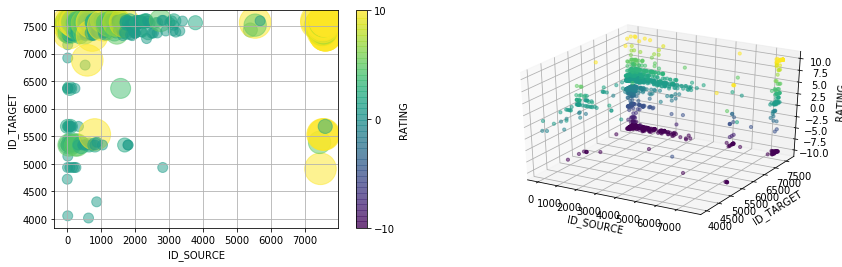

In [14]:
scatter(data_12)

In [15]:
sim = cosine_similarity(data_12)

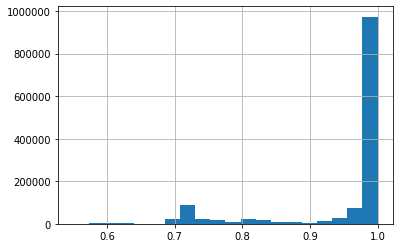

In [16]:
histogram(sim)

Dado que la mayoría de puntos analizados se encuentran cercanos al valor $1$, podemos suponer que se encuentran relativamente cerca o son parecidos por lo tanto se escoge un valor de $convDist=0.1$. Dicho de otra forma, el algoritmo debería converger relativamente rápido ya que los puntos se encuentran más o menos agrupados.

2.- Corra su algoritmo con los siguientes valores de $k = \{10, 20, 30, 40, 50\}$. Corra cada configuración 5 veces, registrando el número de iteraciones y el tiempo. Para cada valor de $k$, haga un box plot del tiempo de ejecución y otro del número de iteraciones. Comente sus resultados.

In [17]:
K = list(range(10, 51, 10))
times = list()

In [18]:
for k in K:
    print("k:", k)
    time = %timeit -r 5 -n 1 -o -q !bash run.sh $DATA_DIR $k .1 2>/dev/null
    times.append(time)

k: 10
Iterations: 64
Iterations: 29
Iterations: 49
Iterations: 85
Iterations: 36
k: 20
Iterations: 76
Iterations: 79
Iterations: 67
Iterations: 66
Iterations: 71
k: 30
Iterations: 97
Iterations: 93
Iterations: 86
Iterations: 82
Iterations: 145
k: 40
Iterations: 137
Iterations: 186
Iterations: 177
Iterations: 230
Iterations: 110
k: 50
Iterations: 129
Iterations: 114
Iterations: 238
Iterations: 150
Iterations: 332


In [19]:
res = getResults('./data/output/', K)

In [20]:
iterations = np.array([
    [int(r[0,0]) for r in res[0]],
    [int(r[0,0]) for r in res[1]],
    [int(r[0,0]) for r in res[2]],
    [int(r[0,0]) for r in res[3]],
    [int(r[0,0]) for r in res[4]]
])

## Boxplots

### Tiempos de ejecución

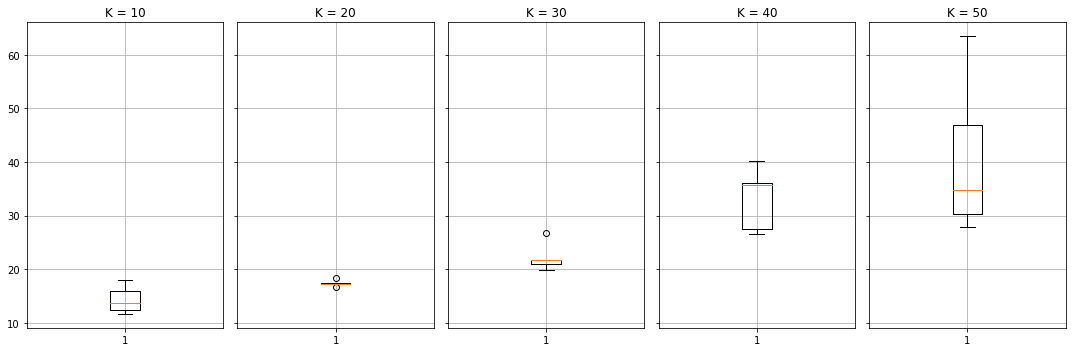

In [21]:
boxplot(times)

Es clara la necesidad de más tiempo de cómputo a medida que se incrementa el valor $k$.

### Número de iteraciones

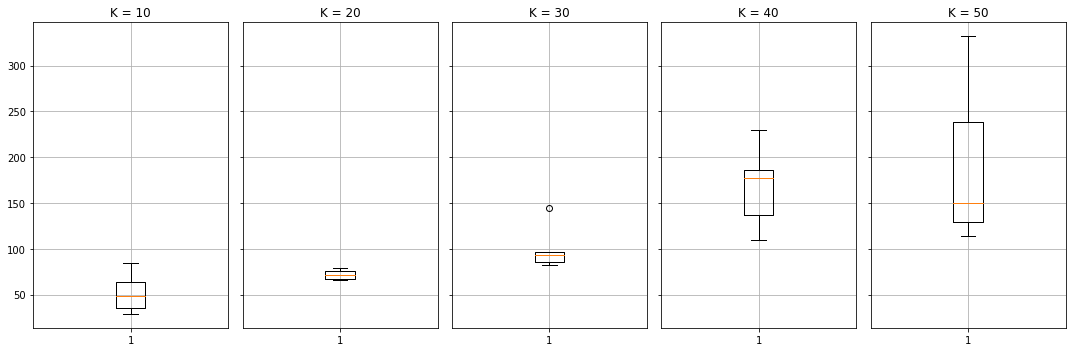

In [22]:
boxplot(iterations, False)

Similar al caso anterior, es necesario un número mayor de iteraciones al momento de buscar más centroides.

### Ejemplo de experimentos

K = 10


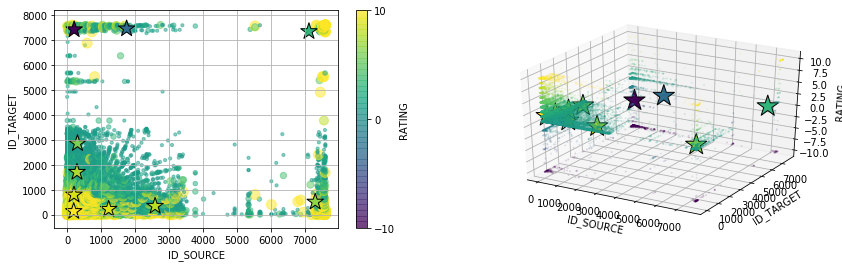

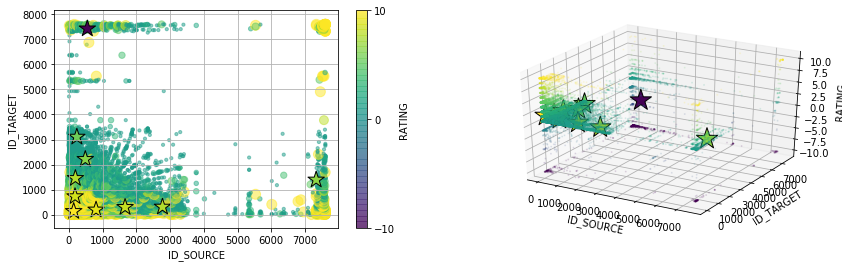

K = 20


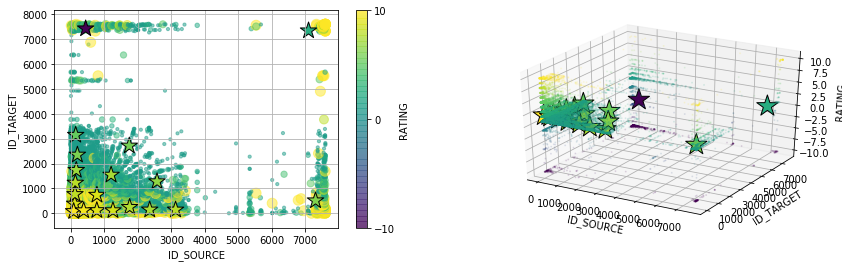

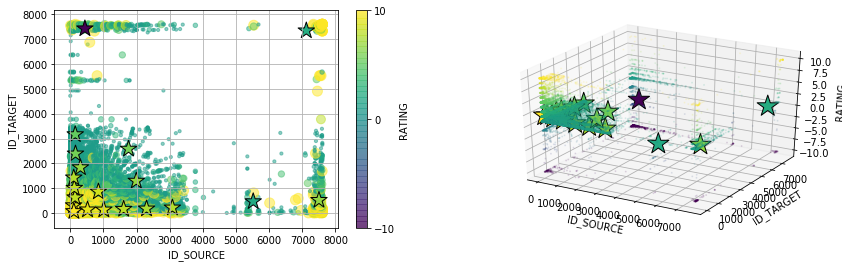

K = 30


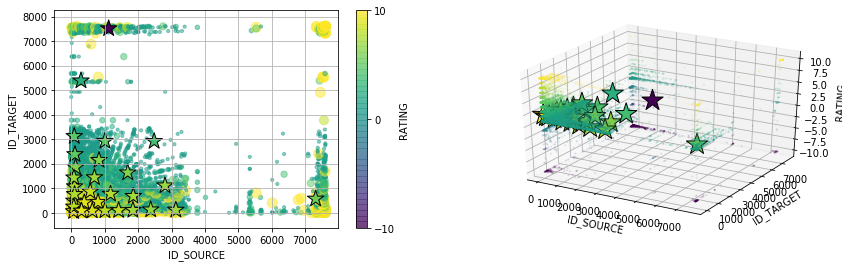

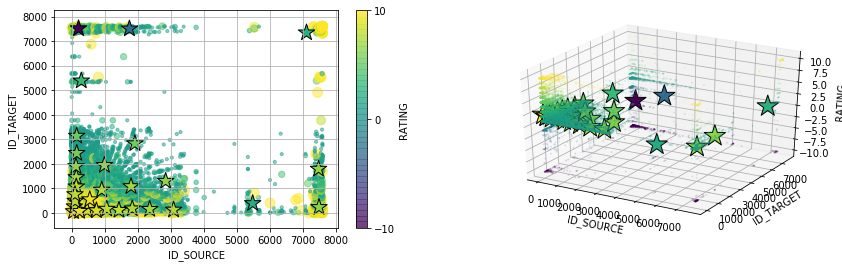

K = 40


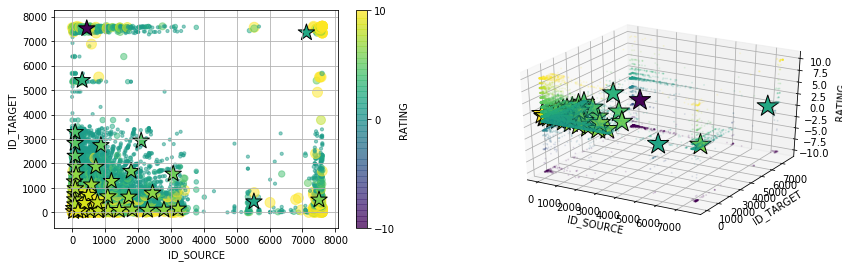

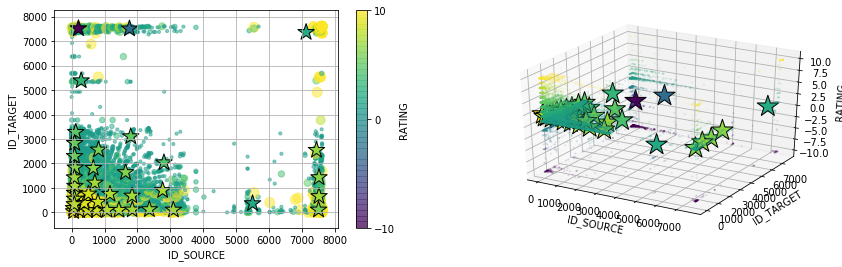

K = 50


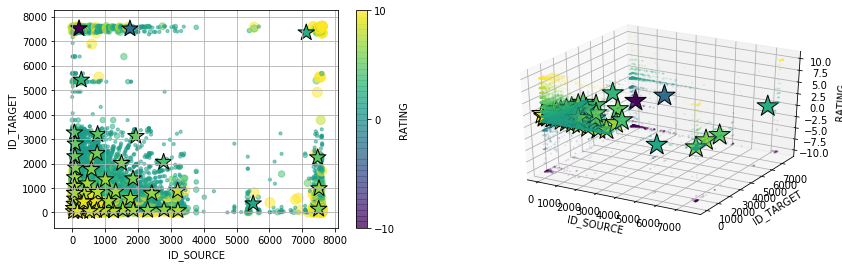

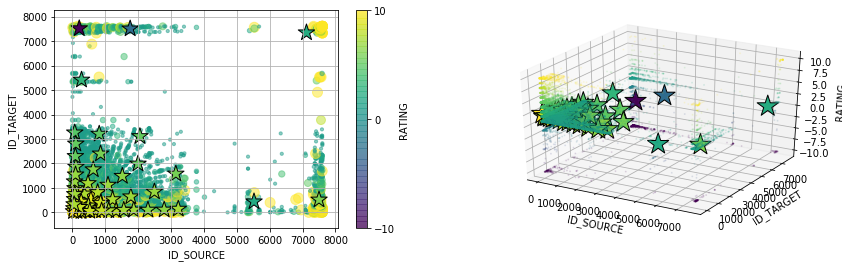

In [23]:
for i in range(5):
    print("K =", 10 * (i+1))
    scatter(data, res[i][0][1:])
    scatter(data, res[i][-1][1:])

Se puede notar que el algoritmo es sensible a la selección de centroides iniciales, es decir, se obtienen distintos resultados según la inicialización que se utilice. Para este ejemplo se inicializó con una muestra aleatoria de los datos.

## Conclusiones

En esta tarea implementamos el algoritmo $k$-means para la manipulación de una cantidad considerable de datos utilizando el *Framework Spark*. Se obtuvieron resultados interesantes sobre todo en los tiempos de ejecución considerando el volumen de datos con el que se trabajó.

El procesamiento de grandes volumenes de datos es una problemática latente en la actualidad, por lo que herramientas como *Spark* nos permiten manipularlos de una forma un poco más cómoda. Principalmente esta herramienta evita el manejo explícito de técnicas de alto rendimiento como programación paralela o distribuida.

La principal dificultad de este trabajo estuvo en la configuración de las herramientas y dependencias para el funcionamiento del *Framework*. 

## Referencias

1. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html
2. https://en.wikipedia.org/wiki/K-means_clustering